<a href="https://colab.research.google.com/github/shotaseno/S_BERT/blob/main/S_BERT_capital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://qiita.com/jovyan/items/4c4920a6e25333920006#%E5%95%8F%E9%A1%8C%E8%A8%AD%E5%AE%9A

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!git clone https://github.com/google-research/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 328.28 KiB | 4.21 MiB/s, done.
Resolving deltas: 100% (182/182), done.


In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
import sys

sys.path.append('bert/')

import codecs
import collections
import json
import re
import os
import pprint
import numpy as np
import tensorflow as tf

import modeling
import tokenization

from sklearn.manifold import TSNE

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

with tf.compat.v1.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

TPU address is grpc://10.106.125.26:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 3930199796813430489),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17328406445924595030),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14303898517975831101),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10557795510986590975),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6986550437486779229),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 5987587257116468876),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 9623396487617896743),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 17557847237073234641),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 91806706046

In [6]:
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL
print('*****BERT pretrained directory: {}*****'.format(BERT_PRETRAINED_DIR))
!gsutil ls $BERT_PRETRAINED_DIR

LAYERS = [-1,-2,-3,-4]
NUM_TPU_CORES = 8
MAX_SEQ_LENGTH = 87
BERT_CONFIG = BERT_PRETRAINED_DIR + '/bert_config.json'
CHKPT_DIR = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
VOCAB_FILE = BERT_PRETRAINED_DIR + '/vocab.txt'
INIT_CHECKPOINT = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
BATCH_SIZE = 128

*****BERT pretrained directory: gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12*****
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_config.json
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.index
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.meta
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/checkpoint
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/vocab.txt


In [7]:
class InputExample(object):

  def __init__(self, unique_id, text_a, text_b=None):
    self.unique_id = unique_id
    self.text_a = text_a
    self.text_b = text_b

class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
    self.unique_id = unique_id
    self.tokens = tokens
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.input_type_ids = input_type_ids

def input_fn_builder(features, seq_length):
  """Create an 'input_fn' closure to be passed to TPUEstimator."""

  all_unique_ids = []
  all_input_ids = []
  all_input_mask = []
  all_input_type_ids = []

  for feature in features:
    all_unique_ids.append(feature.unique_id)
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_input_type_ids.append(feature.input_type_ids)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "unique_ids": tf.constant(all_unique_ids, shape=[num_examples], dtype=tf.int32),
        "input_ids": tf.constant(all_input_ids, shape=[num_examples, seq_length], dtype=tf.int32),
        "input_mask": tf.constant(all_input_mask, shape=[num_examples, seq_length], dtype=tf.int32),
        "input_type_ids": tf.constant(all_input_type_ids, shape=[num_examples,seq_length],dtype=tf.int32),
    })

    d = d.batch(batch_size=batch_size, drop_remainder=False)

    return d
  
  return input_fn

def model_fn_builder(bert_config, init_checkpoint, layer_indexes, use_tpu, use_one_hot_embeddings):
  """Returns 'model_fn' for TPUEstimator."""

  def model_fn(features, labels, mode, params):
    """The 'model_fn' for TPUEstimator."""

    unique_ids = features["unique_ids"]
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    input_type_ids = features["input_type_ids"]

    model = modeling.BertModel(
        config=bert_config,
        is_training=False,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=input_type_ids,
        use_one_hot_embeddings=use_one_hot_embeddings
    )

    if mode != tf.estimator.ModeKeys.PREDICT:
      raise ValueError("Only PREDICT modes are supported: %s" %(mode))

    tvars = tf.trainable_variables()
    scaffold_fn = None
    (assignment_map, initialized_variable_names) = modeling.get_assignment_map_from_checkpoint(
        tvars, init_checkpoint
    )

    if use_tpu:

      def tpu_scaffold():
        tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
        return tf.train.Scaffold()

        scaffold_fn = tpu_scaffold
    else:
      tf.train.init_from_checkpoint(init_checkpoint,assignment_map)
    
    tf.logging.info("***Trainable Variables")
    for var in tvars:
      init_string = ""
      if var.name in initialized_variable_names:
        init_string = ", *INIT_FROM_CKPT*"
      tf.logging.info("name=%s, shape=%s%s", var.name, var.shape, init_string)

    all_layers = model.get_all_encoder_layers()

    predictions = {
        "unique_id": unique_ids,
    }

    for (i,layer_index) in enumerate(layer_indexes):
      predictions["layer_output_%d" %i] = all_layers[layer_index]

    output_spec = tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode, predictions=predictions,scaffold_fn=scaffold_fn
    )
    return output_spec
  
  return model_fn

def convert_examples_to_features(examples, seq_length, tokenizer):
  """Loads a data file into a list of 'InputBatch' s."""

  features = []
  for (ex_index, example) in enumerate(examples):
    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
      tokens_b = tokenizer.tokenize(example.text_b)
      
    if tokens_b:
      _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
    else:
      if len(tokens_a) > seq_length -2:
        tokens_a = tokens_a[0:(seq_length-2)]

      tokens = []
      input_type_ids = []
      tokens.append("[CLS]")
      input_type_ids.append(0)
      for token in tokens_a:
        tokens.append(token)
        input_type_ids.append(0)
      tokens.append("[SEP]")
      input_type_ids.append(0)

    if tokens_b:
      for token in tokens_b:
        tokens.append(token)
        input_type_ids.append(1)
      tokens.append("[SEP]")
      input_type_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    input_mask = [1] * len(input_ids)

    while len(input_ids) < seq_length:
      input_ids.append(0)
      input_mask.append(0)
      input_type_ids.append(0)

    assert len(input_ids) == seq_length
    assert len(input_mask) == seq_length
    assert len(input_type_ids) == seq_length

    if ex_index < 5:
      tf.logging.info("***Example***")
      tf.logging.info("unique_id: %s" % (example.unique_id))
      tf.logging.info("tokens: %s" % "".join([tokenization.printable_text(x) for x in tokens]))
      tf.logging.info("input_ids: %s" % "".join([str(x) for x in input_ids]))
      tf.logging.info("input_mask: %s" % "".join([str(x) for x in input_mask]))
      tf.logging.info(
          "input_type_ids: %s" % " ".join([str(x) for x in input_type_ids]))


    features.append(
        InputFeatures(
            unique_id=example.unique_id,
            tokens=tokens,
            input_ids=input_ids,
            input_mask=input_mask,
            input_type_ids=input_type_ids
        )
    )
    return features

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
  """Truncates a sequence pair in place to the maximum length."""

  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_length:
      break
    if len(tokes_a) > len(tokens_b):
      tokens_a.pop()
    else:
      tokens_b.pop()
  
def read_sequence(input_sentences):
  examples = []
  unique_id = 0
  for sentence in input_sentences:
    line = tokenization.convert_to_unicode(sentence)
    examples.append(InputExample(unique_id=unique_id, text_a=line))
    unique_id += 1
  return examples

def get_features(input_text, dim=768):

  layer_indexes = LAYERS

  bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)

  tokenizer = tokenization.FullTokenizer(
      vocab_file=VOCAB_FILE, do_lower_case=True)

  is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2
  tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
  run_config = tf.contrib.tpu.RunConfig(
      cluster=tpu_cluster_resolver,
      tpu_config=tf.contrib.tpu.TPUConfig(
          num_shards=NUM_TPU_CORES,
          per_host_input_for_training=is_per_host))

  examples = read_sequence(input_text)

  features = convert_examples_to_features(
      examples=examples, seq_length=MAX_SEQ_LENGTH, tokenizer=tokenizer)

  unique_id_to_feature = {}
  for feature in features:
    unique_id_to_feature[feature.unique_id] = feature

  model_fn = model_fn_builder(
      bert_config=bert_config,
      init_checkpoint=INIT_CHECKPOINT,
      layer_indexes=layer_indexes,
      use_tpu=True,
      use_one_hot_embeddings=True)

  estimator = tf.contrib.tpu.TPUEstimator(
      use_tpu=True,
      model_fn=model_fn,
      config=run_config,
      predict_batch_size=BATCH_SIZE,
      train_batch_size=BATCH_SIZE)

  input_fn = input_fn_builder(
      features=features, seq_length=MAX_SEQ_LENGTH)

  for result in estimator.predict(input_fn, yield_single_examples=True):
    unique_id = int(result["unique_id"])
    feature = unique_id_to_feature[unique_id]
    output = collections.OrderedDict()
    for (i, token) in enumerate(feature.tokens):
      layers = []
      for (j, layer_index) in enumerate(layer_indexes):
        layer_output = result["layer_output_%d" % j]
        layer_output_flat = np.array([x for x in layer_output[i:(i + 1)].flat])
        layers.append(layer_output_flat)
      output[token] = sum(layers)[:dim]
  
  return output

In [8]:
tf.io.gfile

<module 'tensorflow._api.v1.io.gfile' from '/tensorflow-1.15.2/python3.7/tensorflow_core/_api/v1/io/gfile/__init__.py'>

In [9]:
import pandas as pd

In [10]:
def extract_bert_vectors(input_path, target_layer, target_token): 
  with open(input_path, 'r') as f:
      output_jsons = f.readlines()

  vectors = []
  for output_json in output_jsons:
      output = json.loads(output_json)
      for feature in output['features']:
          if feature['token'] != target_token: continue
          for layer in feature['layers']:
              if layer['index'] != target_layer: continue
              vectors.append(layer['values'])
  return np.array(vectors)

In [11]:
def show_sim_mat(sim_mat, texts, title=None, export_fig=False):
  sns.set(font_scale=1)
  g = sns.heatmap(
      sim_mat,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(texts, rotation='vertical')
  g.set_yticklabels(texts, rotation=False)
  if title:
    plt.title(title, fontsize=12)
  if export_fig:
    plt.savefig(export_fig, bbox_inches='tight')
  plt.show()

In [12]:
def cos_sim(v1, v2):
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def calc_sim_mat(arr):
  num = len(arr)
  sim_mat = np.zeros((num, num))
  norm = np.apply_along_axis(lambda x: np.linalg.norm(x), 1, arr)
  normed_arr = arr / np.reshape(norm, (-1,1))
  for i, vec in enumerate(normed_arr):
    sim = np.dot(normed_arr, np.reshape(vec, (-1,1)))
    sim = np.reshape(sim, -1) 
    sim_mat[i] = sim
  return sim_mat


In [13]:
capital_sentences = [
"Mahdi Mohammed loyalists were holding out in the northern fringes of the capital",
"The city of Brisbane, capital and chief port of Queensland, is named after Sir Thomas Makdougall Brisbane",
"Before they left the Irish capital, they told how pure joy replaced unbearable anguish when they learned their little girl",
"unnelers were working on Thames Water's 250 million ring main round the capital",
"Spurs have beaten them in their last nine visits to the capital",
"we usually have a similar document on the minor capital works",
"The British bourgeoisie is going to have to look elsewhere for capital appreciation",
"Hence a preference as to dividend will not imply a preference as to capital",
"if they are given a preferential right to a return of capital they are presumed to be non-participating in surplus assets",
"the company may merge the relevant share capital",
"For ease of recognition we denote polynomials in Zx by capital letters",
"what we have done is is is print our names in capital letters there",
"the Rapporteur felt able to declare, in a passage set in capital letters",
"Do not go to EuroDisney, or patronise anywhere or anything with a capital letter in the middle of its name",
"a grammatical sentence is expected to begin with a capital letter and end with a full stop and people are expected to write in sentences"
]
# s_capital_labels = [0,0,0,0,0,1,1,1,1,1,2,2,2,2]

with open("/content/capital_texts.txt", 'w') as f:
  f.writelines(s + '\n' for s in capital_sentences)

In [14]:
!python ./bert/extract_features.py \
  --input_file=/content/capital_texts.txt \
  --output_file=/content/capital_output.jsonl \
  --vocab_file=gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/vocab.txt \
  --bert_config_file=gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_config.json \
  --init_checkpoint=gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt \
  --do_lower=True \
  --layers 0,1,2,3,4,5,6,7,8,9,10,11



W0623 22:04:48.272235 140656979978112 module_wrapper.py:139] From ./bert/extract_features.py:344: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0623 22:04:48.272414 140656979978112 module_wrapper.py:139] From ./bert/extract_features.py:344: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0623 22:04:48.272568 140656979978112 module_wrapper.py:139] From /content/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

2021-06-23 22:04:48.280468: W tensorflow/core/platform/cloud/google_auth_provider.cc:178] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Cancelled: GCE check skipped due to presence of $NO_GCE_CHECK environment variable.".
2021-06-23 22:04:48.337392: W tenso

In [15]:
bert_vectors = extract_bert_vectors('/content/capital_output.jsonl', target_layer=10, target_token='capital')
print(bert_vectors.shape)

(15, 768)


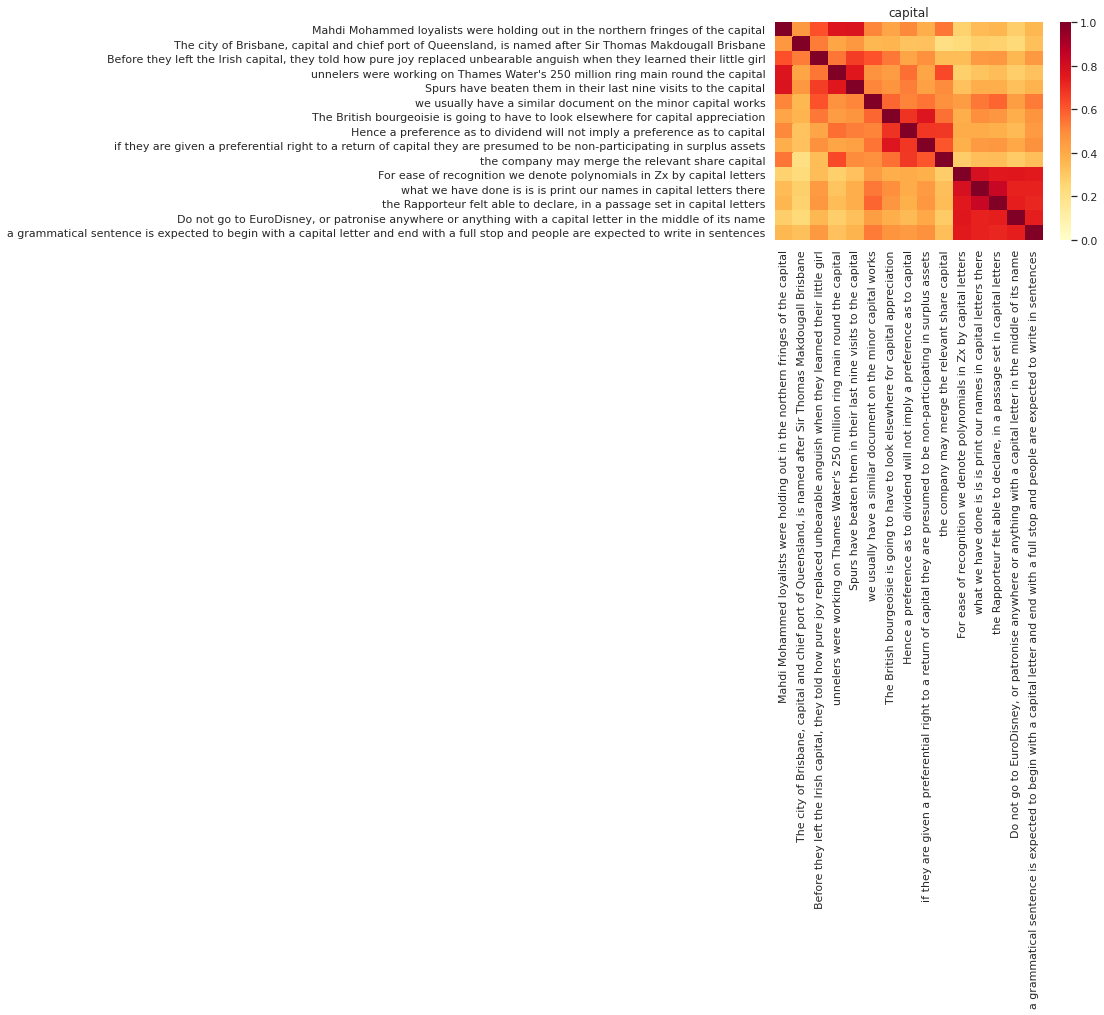

In [16]:
import seaborn as sns

bert_sim_mat = calc_sim_mat(bert_vectors)

show_sim_mat(bert_sim_mat, capital_sentences, title='capital')